In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.ndimage
from keras.preprocessing import image
keras.__version__


Using TensorFlow backend.


'2.2.4'

# Wstęp


W tym projekcie tworzę konwolucyjną sieć neuronową, która będzia miała na celu rozpoznawanie na podstawie zdjęć z rentgena czy pacjent choruje na zapalenie płuc, czy nie. W tym celu korzystam z zestawu danych, znajdującego się na portalu kaggle, o nazwie Chest X-ray Images (Pneumonia): https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Zestaw jest oryginalnie podzielony na 3 foldery train, test i val.
Do uczenia i testowania sieci wykorzystam zdjęcia z folderów train i test.
Do notebooka zostaną dołączone tylko zdjęcia do których ścieżki podane są w poniższych komórkach ze względu na rozmiar zestawu (1.2GB)

Zacznijmy od wczytania danych z dysku i poddania ich prepocessingowi. W tym kroku tworzę generator, którym będę modyfikował zdjęcia w celu późniejszego uczenia sieci neuronowej metodą augmentacji
W pierwszej komórce wybrałem kilka przypadkowych zdjęć z zestawu treningowego dla zobrazowania z jakimi danymi mamy do czynienia




In [2]:
img_paths = ["data/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg",
                "data/chest_xray/train/NORMAL/NORMAL2-IM-0383-0001.jpeg",
                 "data/chest_xray/train/NORMAL/NORMAL2-IM-1089-0001.jpeg.",
                 "data/chest_xray/train/NORMAL/NORMAL2-IM-0966-0001.jpeg",
                 "data/chest_xray/train/NORMAL/NORMAL2-IM-0383-0001.jpeg"
            ]
        
img_list = [image.load_img(img_path) for img_path in img_paths]

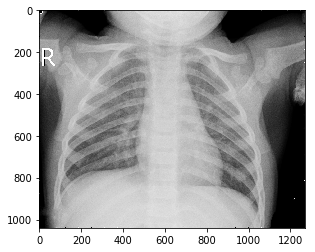

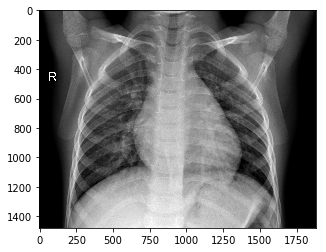

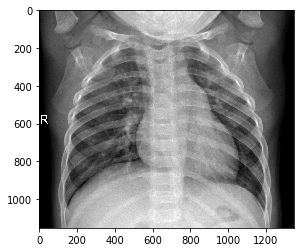

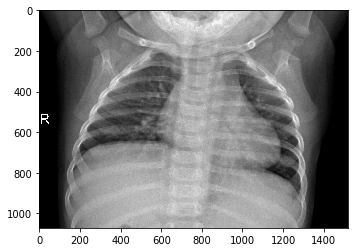

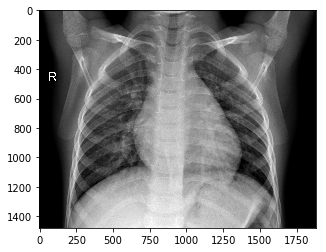

In [3]:
i = 0
for img in img_list:
    plt.figure(i)
    imgplot = plt.imshow(img)
    i += 1

In [4]:
from keras.preprocessing.image import ImageDataGenerator

trainDataGenerator = ImageDataGenerator(rescale=1./255,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                        shear_range=0.2
                                       )

testDataGenerator = ImageDataGenerator(rescale=1./255)

trainingSet = trainDataGenerator.flow_from_directory('data/chest_xray/train',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

testingSet = testDataGenerator.flow_from_directory('data/chest_xray/test',
                                                 target_size = (128, 128),
                                                 batch_size =32,
                                                 class_mode = 'binary')



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Prezentacja przykładowych danych

Poniżej możemy zobaczyć jedno zdjęcie ze zbioru treningowego, które zostało poddane preprocessingowi i dzięki temu uzyskaliśmy różne wariacje tego zdjęcia. Zdjęcie przedstawia płuca zdrowego pacjenta.

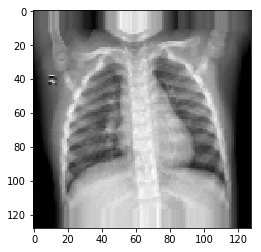

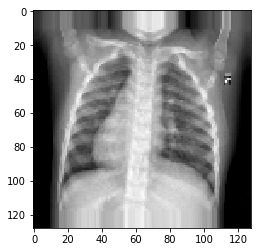

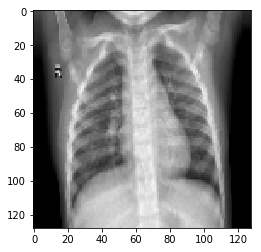

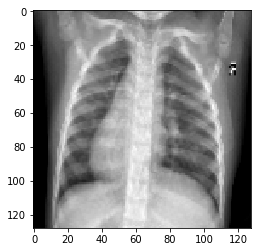

In [5]:


img_path = 'data/chest_xray/train/NORMAL/IM-0213-0001.jpeg'

img = image.load_img(img_path, target_size=(128, 128))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i = 0
for batch in trainDataGenerator.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        
        
plt.show()

## Budowa modelu sieci neuronowej

In [6]:
from keras import layers, models, optimizers
def buildModel():
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation = 'relu',
                           input_shape=(128,128,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(512, activation='relu'))

    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(512, activation='relu'))

    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(512, activation='relu'))
    
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(512, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(), 
                  metrics=['accuracy'])
    return model


W tym miejscu można zobaczyć opis modelu sieci neuronowej, z jakich składa się wartsw i jakiego 'kształtu' są dane

In [7]:
network = buildModel()
network.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxP

#### Rozpoczynamy trenowanie modelu sieci.

In [8]:
history = network.fit_generator(trainingSet, 
                              steps_per_epoch=163,
                              epochs= 50,
                             validation_data=testingSet,
                             validation_steps=20)


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
163/163 [==============================] - 127s 780ms/step - loss: 0.4931 - acc: 0.7866 - val_loss: 0.3359 - val_acc: 0.8606
Epoch 2/50
163/163 [==============================] - 120s 735ms/step - loss: 0.2828 - acc: 0.8819 - val_loss: 0.2977 - val_acc: 0.8702
Epoch 3/50
163/163 [==============================] - 120s 734ms/step - loss: 0.2299 - acc: 0.9082 - val_loss: 0.3018 - val_acc: 0.8894
Epoch 4/50
163/163 [==============================] - 120s 735ms/step - loss: 0.1947 - acc: 0.9233 - val_loss: 0.3995 - val_acc: 0.8638
Epoch 5/50
163/163 [==============================] - 119s 731ms/step - loss: 0.1933 - acc: 0.9250 - val_loss: 0.3900 - val_acc: 0.8798
Epoch 6/50
163/163 [==============================] - 119s 732ms/step - loss: 0.1791 - acc: 0.9333 - val_loss: 0.4047 - val_acc: 0.8574
Epoch 7/50
163/163 [==============================] - 120s 734ms/step - loss: 0.1735 - acc: 0.9333 - val_loss: 0.3447 - val_acc: 0.8702


##### Zapisanie modelu

In [10]:
network.save('pneumonia-detector.h5')

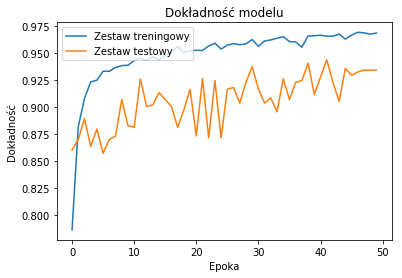

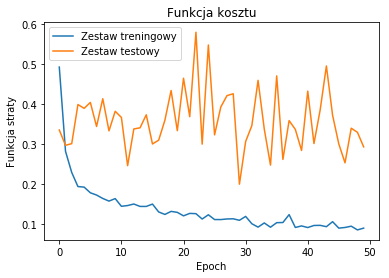

In [11]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Dokładność modelu')
plt.ylabel('Dokładność')
plt.xlabel('Epoka')
plt.legend(['Zestaw treningowy', 'Zestaw testowy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funkcja kosztu')
plt.ylabel('Funkcja straty')
plt.xlabel('Epoch')
plt.legend(['Zestaw treningowy', 'Zestaw testowy'], loc='upper left')
plt.show()

In [33]:
                                                 
print(history.history['val_acc'][-1] * 100 ,'%')


93.42948717948718 %


### Koniec trenowania
Na koniec uzyskaliśmy dokładność na poziomie ok. 93%.
Na wykresach widać, że mamy doczynienia z przypadkiem nadmiernego dofitowania, jednak mimo wszystko różnice w wartości funkcji straty bądź też w dokładności dla zestawu treningowego i testowego nie są ogromne. Strata walidacji miała wyraźne skoki jednak generalnie trzymała mniej więcej jeden poziom ( ok. 0.3 - 0.4). Zdecydowanie lepsze efekty można jeszcze uzyskać modyfikując parametry modelu i trenowania, a także poprzez ewentualne dodanie nowych warstw Dense i Dropout. Wysoce prawdopodobne aby uzyskać jeszcze bardziej wygładzony wykres walidacji należałoby uczyć się na co najnmiej 100 epokach, jednak wymaga do dużo zasobów obliczeniowych i czasu na wytrenowanie modelu.